In [33]:
import os
from datetime import datetime

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Subset
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAccuracy
from torch import optim, nn
from torchvision import datasets, models, transforms as v2
from tqdm import tqdm

## Анализ Данных

In [34]:
def analyze_class_distribution(dataset_path: str) -> dict[str, int]:
    """
    Формирует словарь, содержащий имя класса и количество его экземпляров в датасете.
    Parameters:
        dataset_path (str): путь к датасете для анализа
    Returns:
        dict[str, int]: словарь, где ключом является имя класса, а значением — количество его экземпляров
    """
    class_counts = {}
    for classname in os.listdir(dataset_path):
        class_counts[classname] = len(os.listdir(os.path.join(dataset_path, classname)))
    return class_counts

In [35]:
def plot_class_distribution(class_counts: dict[str, int], dataset_path: str) -> None:
    """
    Строит частотную гистограмму распределения классов, сохраняет в текущую папку.
    Parameters:
        class_counts: словарь, где ключом является имя класса, а значением — количество его экземпляров
        dataset_path: путь к корневой директории датасета, содержащей поддиректории с изображениями для каждого класса
    Returns:
         None
    """

    dataset_name = os.path.basename(dataset_path)

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.style.use('ggplot')
    plt.figure(figsize=(12, 8))
    plt.bar(classes, counts)
    plt.title("Distribution of classes")
    plt.xlabel("classes")
    plt.ylabel("Amount of images")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


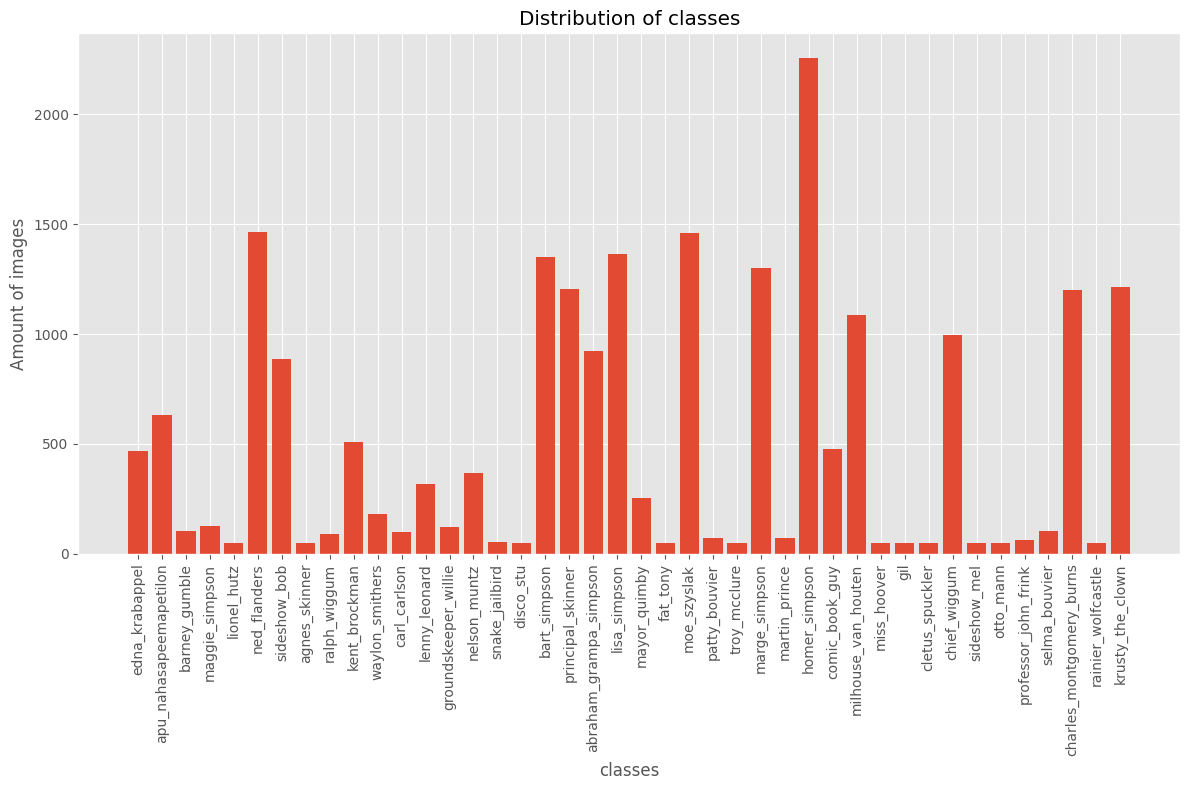

In [36]:
dataset_path = "my_simpsons" # Сюда папку с датасетом
class_count = analyze_class_distribution(dataset_path)
plot_class_distribution(class_count, dataset_path)

## Конфиг

In [37]:
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

DATA_DIR = "my_simpsons"
NUM_CLASSES = 42
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

MODEL_NAME = "MobileNetV2"
MODEL = models.mobilenet_v2(pretrained=False)
MODEL.classifier[1] = nn.Linear(1280, NUM_CLASSES)

MODEL.to(DEVICE)

NUM_EPOCHS = 30
LEARNING_RATE = 0.005

OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)
CRITERION = nn.CrossEntropyLoss()


def get_save_dir(model_name, optimizer, num_epochs, lr):
    """
    Создает имя директории на основе параметров модели, обучения и текущего времени (без года).
    """
    optimizer_name = optimizer.__class__.__name__
    current_time = datetime.now().strftime("%m%d_%H%M%S")
    dir_name = f"{model_name}_{optimizer_name}_epochs{num_epochs}_lr{lr}_{current_time}"
    return dir_name


SAVE_DIR = os.path.join("saved_models",
                        get_save_dir(MODEL_NAME, OPTIMIZER, NUM_EPOCHS,
                                     LEARNING_RATE))
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(SAVE_DIR, "best_model.pth")
GRAPHS_DIR = os.path.join(SAVE_DIR, "graphs")

INFERENCE_TRANSFORM = transform = v2.Compose([
    v2.Resize(IMG_SIZE),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

TRAIN_TRANSFORM = v2.Compose([
        v2.Resize(IMG_SIZE),
        v2.RandomResizedCrop(size=IMG_SIZE, scale=(0.8, 1.0)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomApply([v2.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.1),
                                        scale=(0.9, 1.1))], p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        v2.RandomPerspective(distortion_scale=0.4, p=0.5),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

/home/v.chernodolya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/v.chernodolya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Работа с датасетом
(подготовка DataLoader, деление на train/valid/test)

In [38]:
def load_data(data_dir: str, batch_size: int, train_transform, val_transform) -> \
        tuple[DataLoader, DataLoader, DataLoader, str]:
    """
    Загружает датасет, применяет аугментации "на лету", разделяет датасет на тренировочную, тестовую
    и валидационные части.

    Returns:
        train_loader, test_loader, val_loader, class_names
    """

    test_transform = val_transform

    dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)
    test_dataset = datasets.ImageFolder(root=data_dir, transform=test_transform)

    class_names = sorted(dataset.classes)
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
    dataset.targets = [class_to_idx[dataset.classes[target]] for target in
                       dataset.targets]
    dataset.class_to_idx = class_to_idx
    dataset.classes = class_names

    labels = [dataset.targets[i] for i in range(len(dataset))]

    train_idx, val_test_idx = train_test_split(range(len(dataset)), test_size=0.3, stratify=labels)
    val_idx, test_idx = train_test_split(val_test_idx, test_size=0.6, stratify=[labels[i] for i in val_test_idx])

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(val_dataset, val_idx)
    test_dataset = Subset(test_dataset, test_idx)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=16)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=16)

    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=16)

    return train_loader, test_loader, val_loader, class_names

## Тренировка

In [39]:
import torch
from lgbt import lgbt


def train(
        model: torch.nn.Module,
        device: torch.device,
        optimizer: torch.optim.Optimizer,
        criterion: torch.nn.Module,
        num_epochs: int,
        train_loader,
        val_loader,
        model_save_path: str,
        graphs_dir: str) -> None:
    """
    Обучает модель на тренировочных данных и оценивает ее на валидационных.
    """

    best_val_accuracy = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = []
        correct_train = 0
        total_train = 0

        train_loop = lgbt(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss.append(loss.item())

        mean_train_loss = sum(running_train_loss) / len(running_train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(mean_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = []
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss.append(loss.item())

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        mean_val_loss = sum(running_val_loss) / len(running_val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(mean_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"""Epoch [{epoch + 1}/{num_epochs}], 
        Train loss: {mean_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%
        Val Loss: {mean_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%""")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model, model_save_path)

    plot_train_val_graphs(train_losses, val_losses, train_accuracies, val_accuracies, graphs_dir)
    print("\033[91mTraining complete\033[0m")


## Тест

In [40]:
def test(
        model_best_path: torch.nn.Module,
        device: torch.device,
        num_classes: int,
        class_names: list[str],
        test_loader: DataLoader,
        save_dir: str
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Тестирует модель на тестовом наборе данных и вычисляет метрики для каждого класса.
    Returns:
        precision (np.ndarray) - Массив precision для каждого класса.
        mi
        recall (np.ndarray): Массив recall для каждого класса.

        f1 (np.ndarray): Массив F1-score для каждого класса.

        accuracy_metric = MulticlassAccuracy(num_classes=num_classes, average=None).to(device)

        confusion_matrix (np.ndarray): Матрица ошибок (confusion matrix).
    """

    model = torch.load(model_best_path, map_location=device, weights_only=False)

    accuracy_metric = MulticlassAccuracy(num_classes=num_classes, average=None).to(device)
    precision_metric = MulticlassPrecision(num_classes=num_classes, average=None).to(device)
    recall_metric = MulticlassRecall(num_classes=num_classes, average=None).to(device)
    f1_metric = MulticlassF1Score(num_classes=num_classes, average=None).to(device)

    micro_accuracy_metric = MulticlassAccuracy(num_classes=num_classes, average="micro").to(device)
    micro_precision_metric = MulticlassPrecision(num_classes=num_classes, average="micro").to(device)
    micro_recall_metric = MulticlassRecall(num_classes=num_classes, average="micro").to(device)
    micro_f1_metric = MulticlassF1Score(num_classes=num_classes, average="micro").to(device)

    model.eval()

    labels_true = []
    labels_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Test", unit="batch", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            accuracy_metric.update(predicted, labels)
            precision_metric.update(predicted, labels)
            recall_metric.update(predicted, labels)
            f1_metric.update(predicted, labels)

            micro_accuracy_metric.update(predicted, labels)
            micro_precision_metric.update(predicted, labels)
            micro_recall_metric.update(predicted, labels)
            micro_f1_metric.update(predicted, labels)

            labels_true.extend(labels.cpu().numpy())
            labels_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_metric.compute().cpu().numpy()
    precision = precision_metric.compute().cpu().numpy()
    recall = recall_metric.compute().cpu().numpy()
    f1 = f1_metric.compute().cpu().numpy()

    micro_accuracy = micro_accuracy_metric.compute().item()
    micro_precision = micro_precision_metric.compute().item()
    micro_recall = micro_recall_metric.compute().item()
    micro_f1 = micro_f1_metric.compute().item()

    model_confusion_matrix = confusion_matrix(labels_true, labels_pred)

    plot_test_graphs(accuracy, micro_accuracy, precision, micro_precision, recall, micro_recall, f1, micro_f1, model_confusion_matrix, save_dir, class_names)

    print("\033[91mTesting complete\033[0m")

    return accuracy, precision, recall, model_confusion_matrix

 ## Вывод графиков

In [41]:
def plot_train_val_graphs(train_losses, val_losses, train_accuracies,
                          val_accuracies, save_dir):
    """
    Сохраняет графики потерь и точности в виде изображений.
    """
    plt.style.use("ggplot")

    # График потерь
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    plt.close()

    # График точности
    plt.figure()
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()
    plt.close()


In [42]:
def plot_test_graphs(
        accuracy: np.ndarray[np.float64],
        micro_accuracy: np.float64,
        precision: np.ndarray[np.float64],
        micro_precision: np.float64,
        recall: np.ndarray[np.float64],
        micro_recall: np.float64,
        f1: np.ndarray[np.float64],
        micro_f1: np.float64,
        confusion_matrix: np.ndarray[np.float64],
        save_dir: str,
        class_names: list[str]
) -> None:
    os.makedirs(save_dir, exist_ok=True)

    metrics_per_class = {"Accuracy": (accuracy, micro_accuracy),
                         "Recall": (recall, micro_recall),
                         "Precision": (precision, micro_precision),
                         "F1": (f1, micro_f1)}
    plt.style.use("ggplot")

    num_metrics = len(metrics_per_class)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(15, 6 * num_metrics))

    for ax, (metricName, metric_vals) in zip(axes, metrics_per_class.items()):
        metric_per_class, micro_metric = metric_vals

        ax.bar(class_names, metric_per_class,
            label=f"micro: {np.mean(micro_metric):.2f}")
        ax.set_title("Test_" + metricName + " per Class", fontsize=14)
        ax.set_xlabel("Class")
        ax.set_ylabel(metricName)
        ax.set_xticklabels(class_names, rotation=90)
        ax.grid(axis="y")
        ax.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 12))
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d",
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

## Запуск Процесса

🌈Epoch 1/30  :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[117/117] [42.02s, 2.78it/s]  2it/s]  
Epoch [1/30], 
        Train loss: 3.0565, Train Accuracy: 15.23%
        Val Loss: 3.9021, Val Accuracy: 9.59%
🌈Epoch 2/30  :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[117/117] [41.53s, 2.82it/s]  9it/s]  
Epoch [2/30], 
        Train loss: 2.4132, Train Accuracy: 32.88%
        Val Loss: 2.9543, Val Accuracy: 31.49%
🌈Epoch 3/30  :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[117/117] [41.57s, 2.81it/s]  1it/s]  
Epoch [3/30], 
        Train loss: 1.8970, Train Accuracy: 47.73%
        Val Loss: 2.1255, Val Accuracy: 43.61%
🌈Epoch 4/30  :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[117/117] [42.01s, 2.79it/s]  0it/s]  
Epoch [4/30], 
        Train loss: 1.5637, Train Accuracy: 56.74%
        Val Loss: 1.5211, Val Accuracy: 58.69%
🌈Epoch 5/30  :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[117/117] [36.66s,

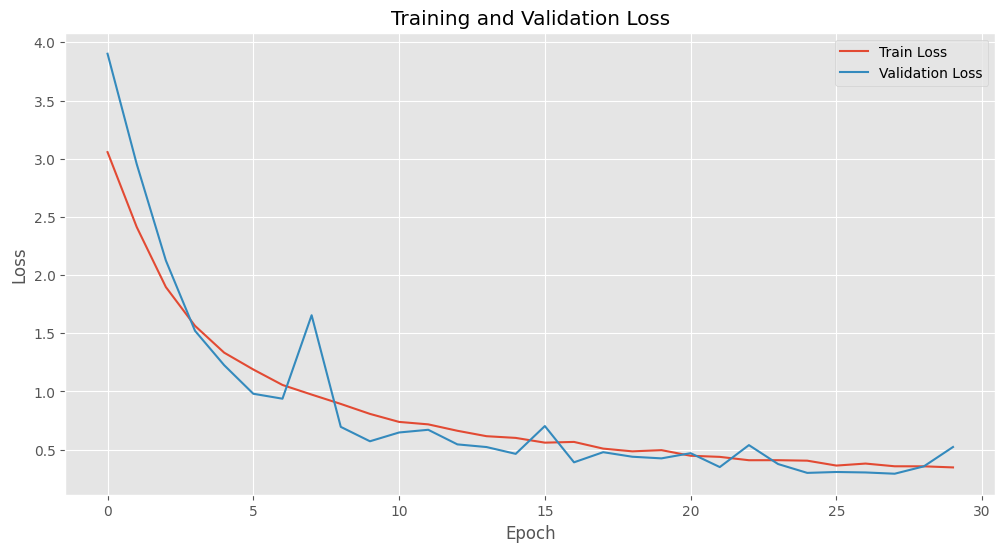

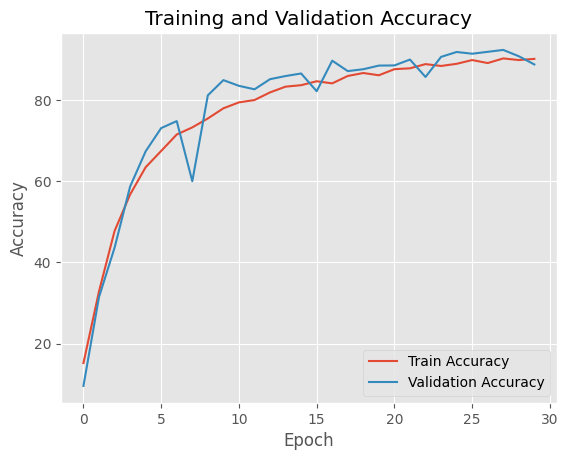

Training complete


/tmp/ipykernel_3805005/3625459764.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=90)
/tmp/ipykernel_3805005/3625459764.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=90)
/tmp/ipykernel_3805005/3625459764.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=90)
/tmp/ipykernel_3805005/3625459764.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=90)


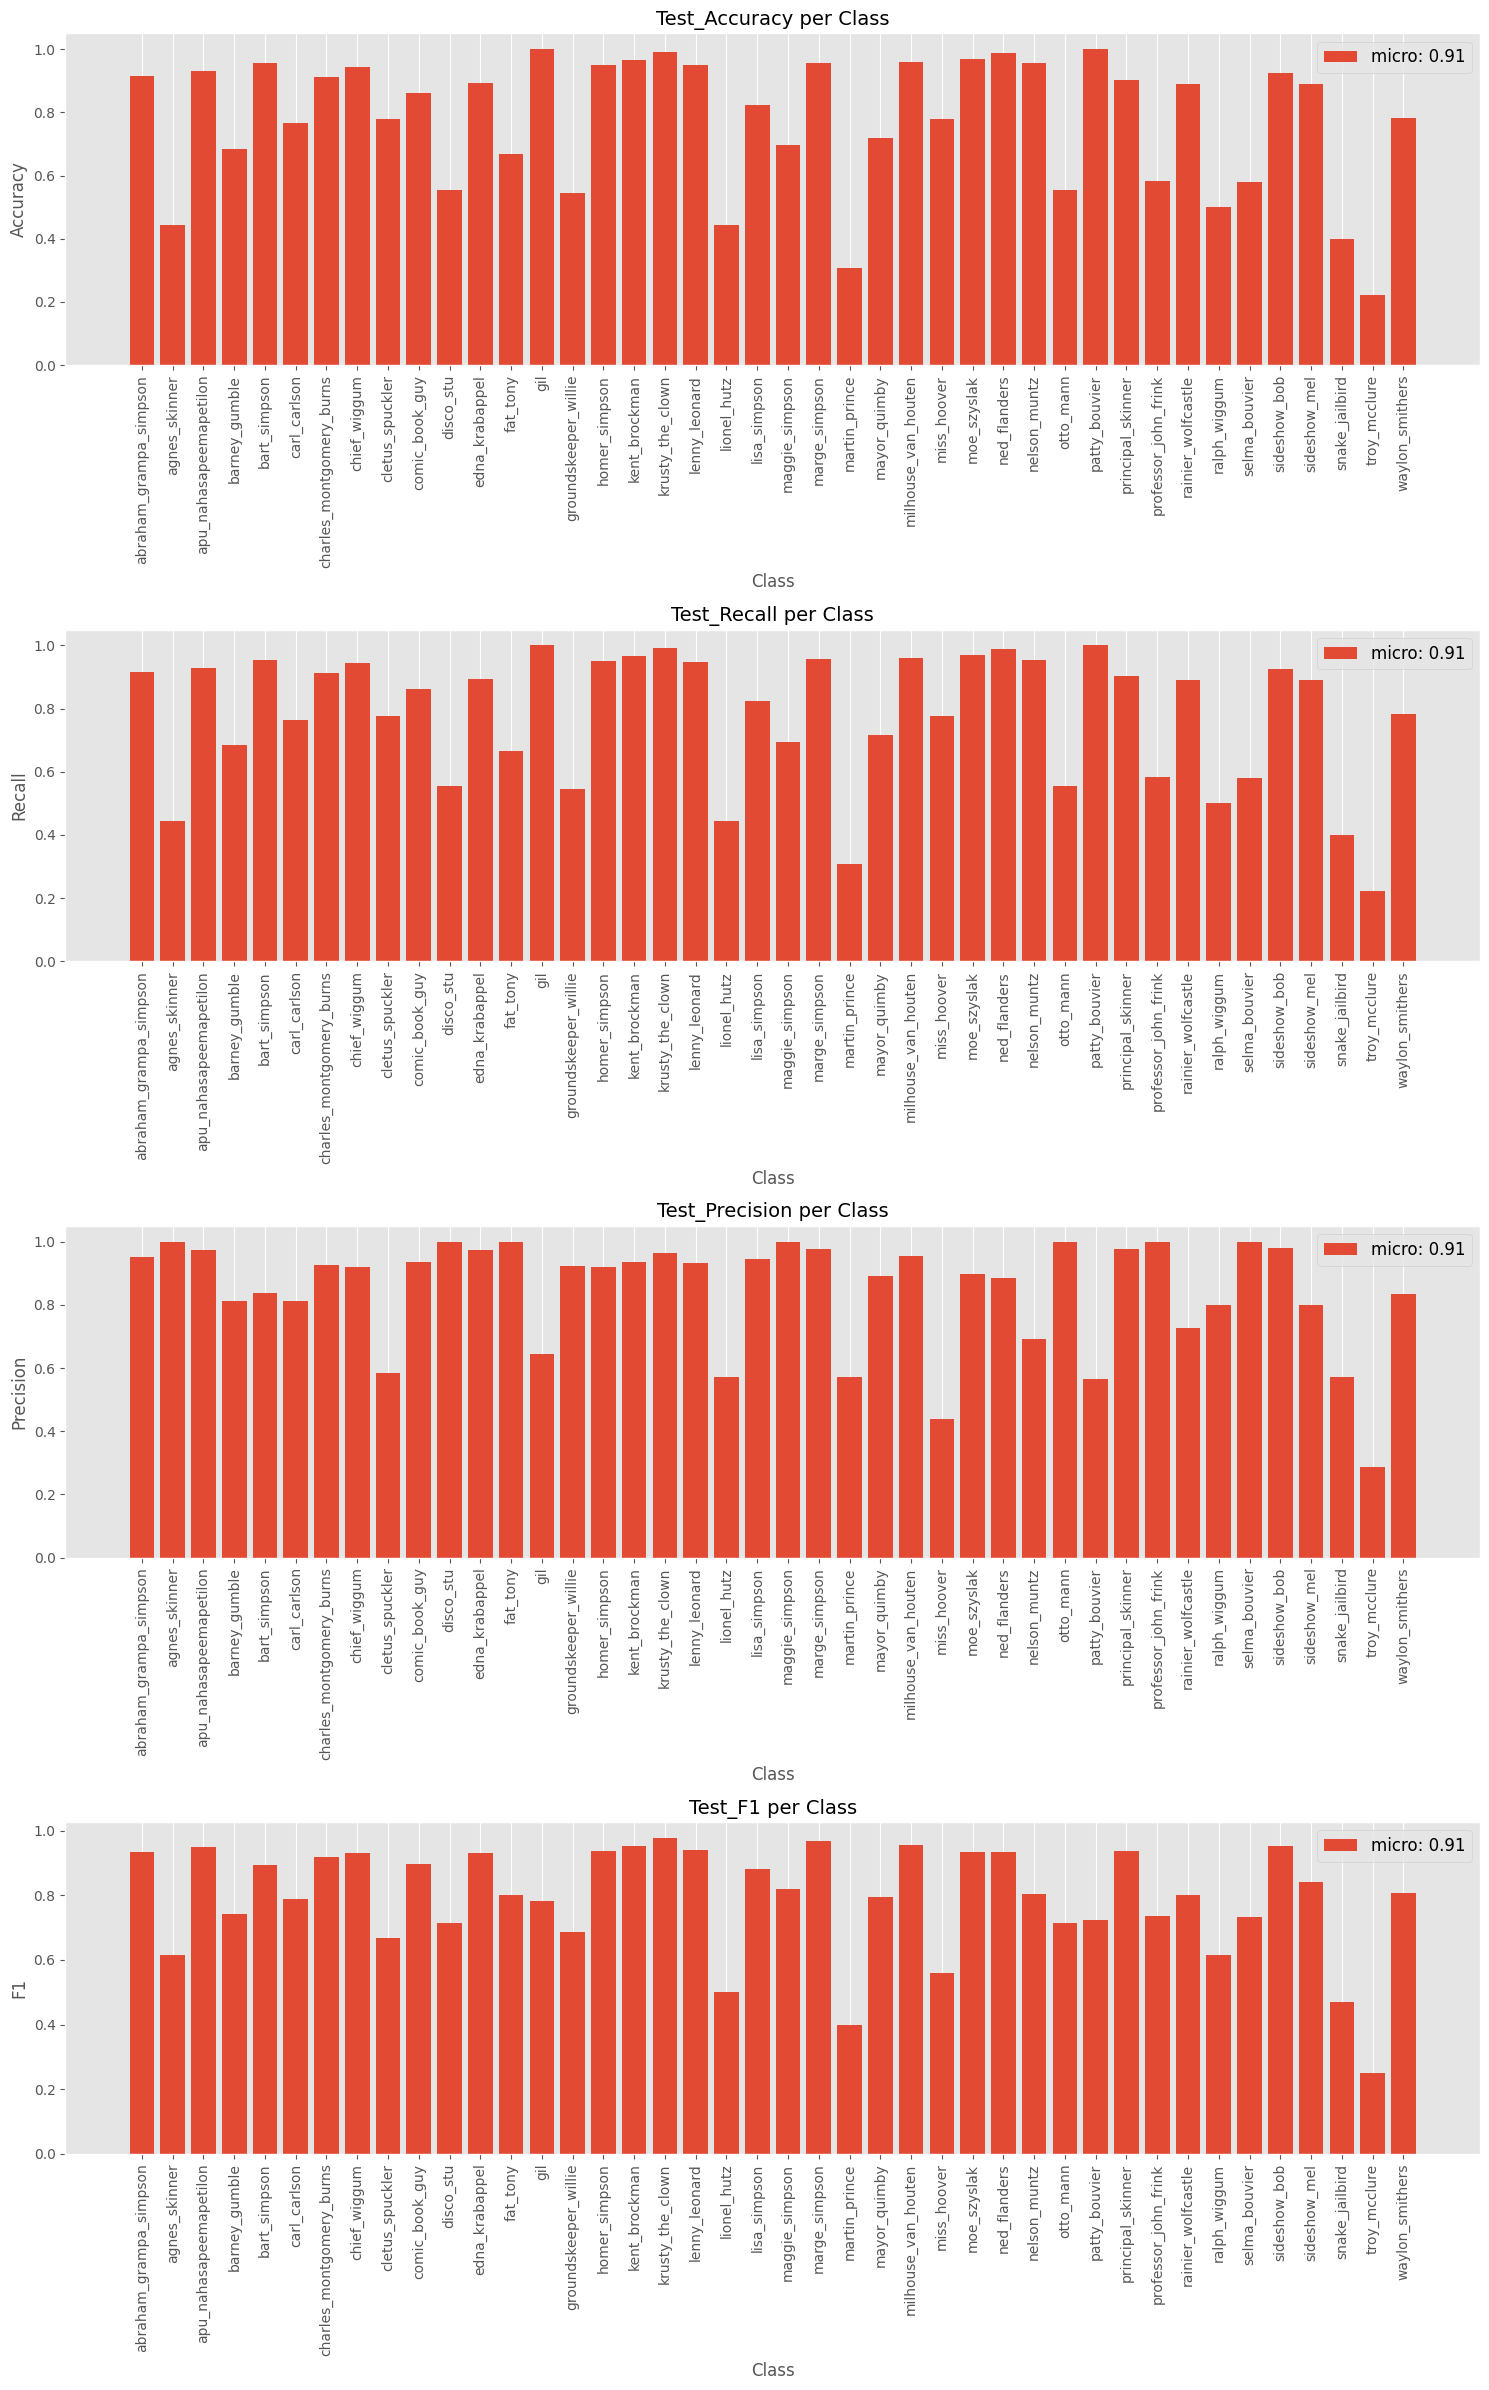

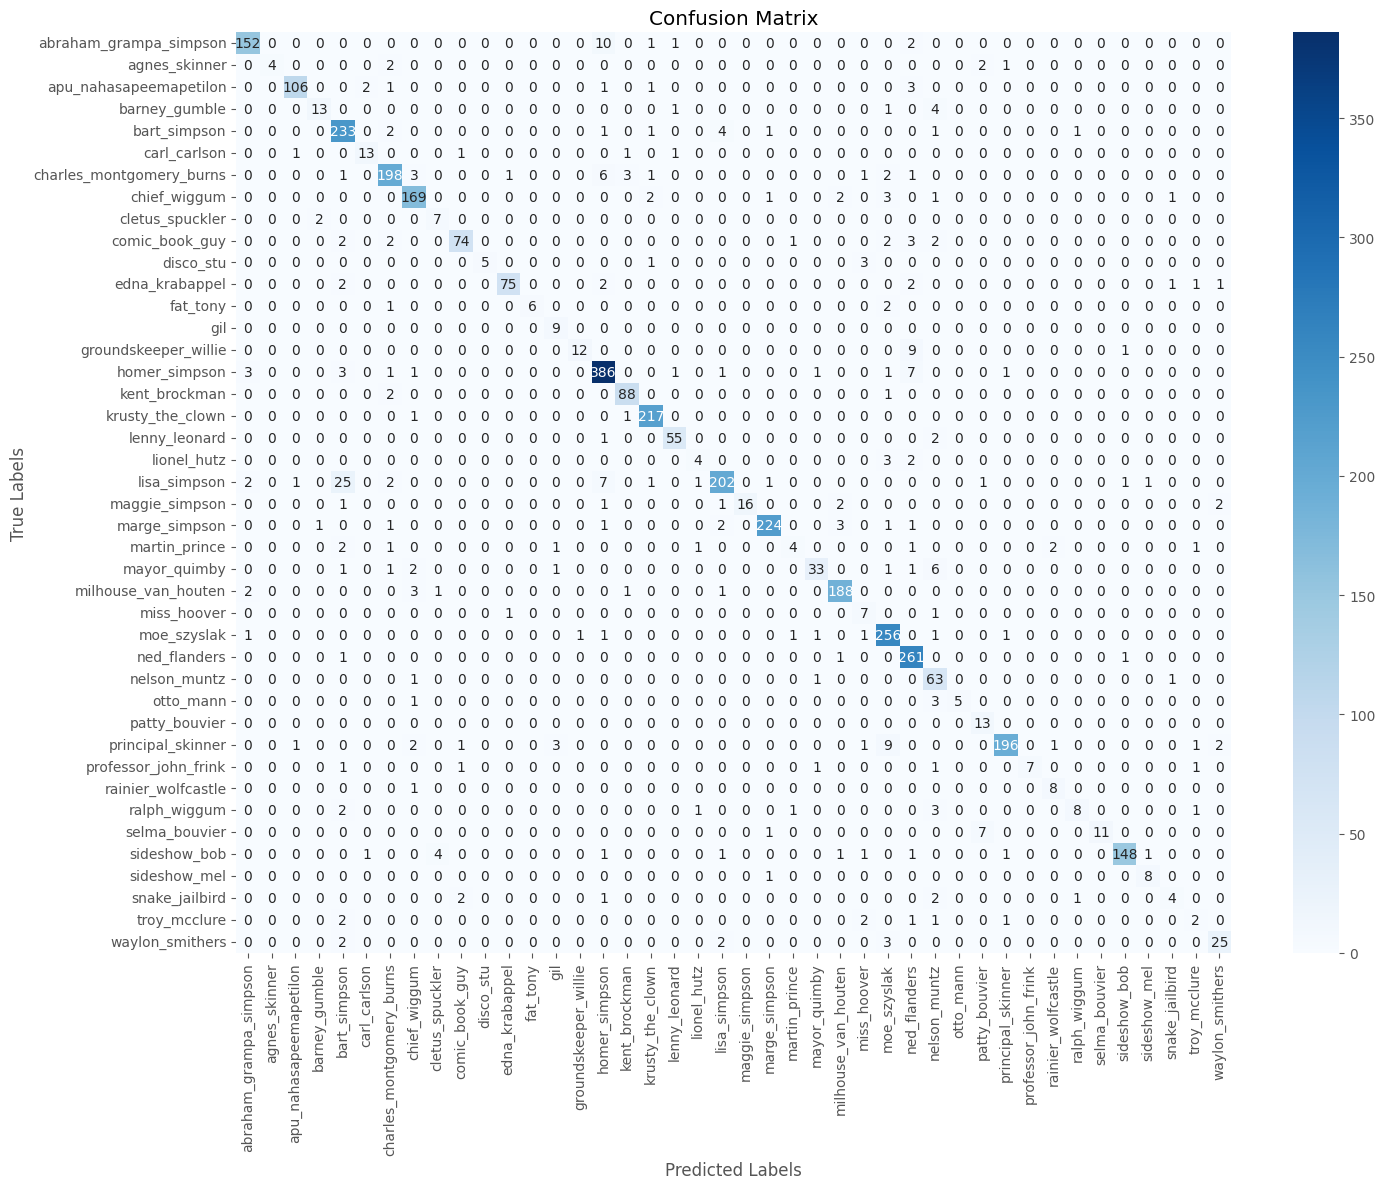

Testing complete


(array([0.91566265, 0.44444445, 0.9298246 , 0.68421054, 0.954918  ,
        0.7647059 , 0.9124424 , 0.94413406, 0.7777778 , 0.8604651 ,
        0.5555556 , 0.89285713, 0.6666667 , 1.        , 0.54545456,
        0.9507389 , 0.96703297, 0.99086756, 0.94827586, 0.44444445,
        0.8244898 , 0.6956522 , 0.95726496, 0.30769232, 0.7173913 ,
        0.9591837 , 0.7777778 , 0.969697  , 0.9886364 , 0.95454544,
        0.5555556 , 1.        , 0.9032258 , 0.5833333 , 0.8888889 ,
        0.5       , 0.57894737, 0.925     , 0.8888889 , 0.4       ,
        0.22222222, 0.78125   ], dtype=float32),
 array([0.95      , 1.        , 0.9724771 , 0.8125    , 0.8381295 ,
        0.8125    , 0.92523366, 0.91847825, 0.5833333 , 0.93670887,
        1.        , 0.97402596, 1.        , 0.64285713, 0.9230769 ,
        0.92124104, 0.9361702 , 0.96444446, 0.9322034 , 0.5714286 ,
        0.94392526, 1.        , 0.9781659 , 0.5714286 , 0.8918919 ,
        0.9543147 , 0.4375    , 0.89824563, 0.8847458 , 0.6923077 ,

In [43]:
train_loader, test_loader, val_loader, class_names = load_data(DATA_DIR, BATCH_SIZE, TRAIN_TRANSFORM,INFERENCE_TRANSFORM)

train(MODEL, DEVICE, OPTIMIZER, CRITERION, NUM_EPOCHS, train_loader,val_loader, MODEL_SAVE_PATH, GRAPHS_DIR)

test(MODEL_SAVE_PATH, DEVICE, NUM_CLASSES, class_names, test_loader, GRAPHS_DIR)